## Bank-BERT using Hugging Face

2024-04-22 05:54:19.003238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 05:54:19.003355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 05:54:19.161936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


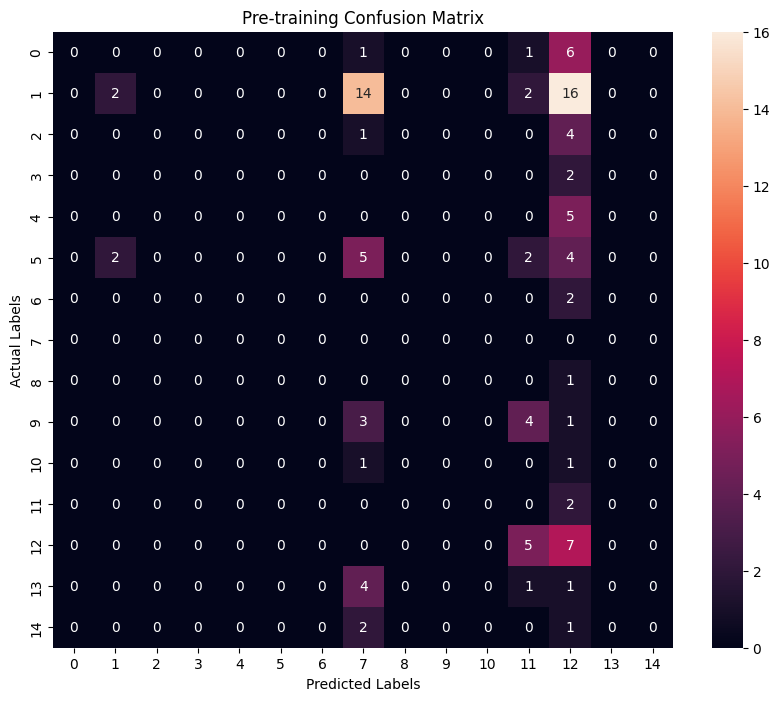

Pre-training Evaluation
Precision: 0.1804, Recall: 0.0874, F1 Score: 0.0598, Accuracy: 0.0874


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
10,2.738700
20,2.770900
30,2.768300
40,2.660900
50,2.621800
60,2.551900
70,2.357100
80,2.487200
90,2.329200
100,2.286700


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Post-training Evaluation
Precision: 0.7960, Recall: 0.8058, F1 Score: 0.7946, Accuracy: 0.8058


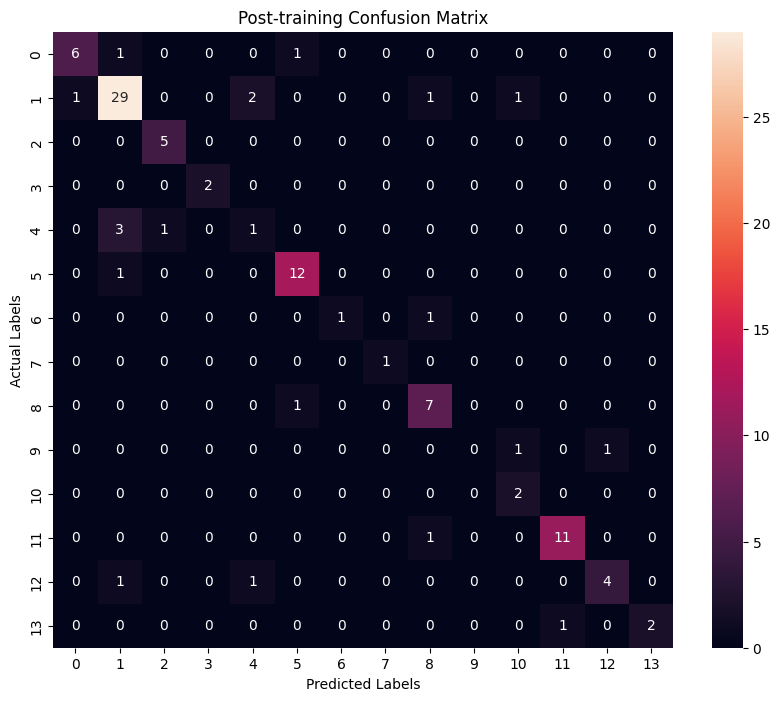

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Training complete
Evaluation results: {'eval_loss': 1.146302580833435, 'eval_runtime': 0.1956, 'eval_samples_per_second': 475.351, 'eval_steps_per_second': 30.668, 'epoch': 15.0}


In [3]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/no-negative-transactions/amex_all_categorized_raw.csv')
df = df[df['Description'] != 'Description']

# Convert descriptions to lowercase
df['Description'] = df['Description'].str.lower()

# Encode categories
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])

# Save the label encoder for later use
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function that operates on a single text item
def tokenize_function(description):
    return tokenizer(description, padding="max_length", truncation=True, max_length=64)

# Apply the tokenization to the entire dataframe
tokenized_data = df['Description'].apply(tokenize_function)
df['input_ids'] = tokenized_data.apply(lambda x: x['input_ids'])
df['attention_mask'] = tokenized_data.apply(lambda x: x['attention_mask'])

# Define a custom dataset
class AmexDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Split dataset into train, validation, and test sets
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Category_encoded'])
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42, stratify=train_val_df['Category_encoded'])

train_dataset = AmexDataset({'input_ids': list(train_df['input_ids']), 'attention_mask': list(train_df['attention_mask'])}, train_df['Category_encoded'].tolist())
val_dataset = AmexDataset({'input_ids': list(val_df['input_ids']), 'attention_mask': list(val_df['attention_mask'])}, val_df['Category_encoded'].tolist())
test_dataset = AmexDataset({'input_ids': list(test_df['input_ids']), 'attention_mask': list(test_df['attention_mask'])}, test_df['Category_encoded'].tolist())

# Initialize model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['Category'].unique()))

# Pre-training evaluation
def evaluate_pretrained_model(model, dataloader, label_encoder):
    classification_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predictions = [classification_pipeline(description)[0]['label'] for description in test_df['Description']]
    predicted_labels = [int(label.split('_')[-1]) for label in predictions]
    true_labels = test_df['Category_encoded'].tolist()

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Pre-training Confusion Matrix")
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    return precision, recall, f1, accuracy

pre_precision, pre_recall, pre_f1, pre_accuracy = evaluate_pretrained_model(model, val_dataset, label_encoder)
print("Pre-training Evaluation")
print(f"Precision: {pre_precision:.4f}, Recall: {pre_recall:.4f}, F1 Score: {pre_f1:.4f}, Accuracy: {pre_accuracy:.4f}")

# Training Arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train and evaluate model
trainer.train()
results = trainer.evaluate()

# Post-training evaluation
classification_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
test_predictions = [classification_pipeline(description)[0]['label'] for description in test_df['Description']]
predicted_labels = [int(label.split('_')[-1]) for label in test_predictions]

post_precision, post_recall, post_f1, post_accuracy = precision_recall_fscore_support(test_df['Category_encoded'], predicted_labels, average='weighted')
post_accuracy = accuracy_score(test_df['Category_encoded'], predicted_labels)

# Display metrics and confusion matrix
print("Post-training Evaluation")
print(f"Precision: {post_precision:.4f}, Recall: {post_recall:.4f}, F1 Score: {post_f1:.4f}, Accuracy: {post_accuracy:.4f}")

conf_matrix = confusion_matrix(test_df['Category_encoded'], predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Post-training Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Save model and tokenizer
model_path = "/kaggle/working/BERT_amex_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# Optionally, push to the hub
model.push_to_hub("mrinoyb2/bankbert", token=huggingface_api_key)
tokenizer.push_to_hub("mrinoyb2/bankbert", token=huggingface_api_key)

print("Training complete")
print("Evaluation results:", results)
